In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Obserwacje z pierwszego zadania**

Moim zdaniem, w trenowaniu modelu kluczowe znaczenie ma odpowiednie przygotowanie danych.
Do najważniejszych kroków należą:
1. usunięcie nieistotnych kolumn, które nie wnoszą wartości informacyjnej do modelu
2. uzupełnienie brakujących wartości
3. dodanie nowych, pochodnych kolumn, co może poprawić zdolność modelu do wychwytywania wzorców,
4. zamiana zmiennych kategorycznych na numeryczne, aby model mógł je prawidłowo interpretować

Usuwanie kolumn

In [3]:
import pandas as pd

titanic_data_frame = pd.read_csv('/content/drive/MyDrive/titanic.csv')

refined_titanic_data_frame = titanic_data_frame.drop(columns=['Name', 'Ticket', 'Cabin'])



Uzupełnienie brakujących wartości

In [4]:
def fill_empty_values_with_median(df, col_name):
  df[col_name] = df[col_name].fillna(df[col_name].median())
  return df

In [5]:
refined_titanic_data_frame = fill_empty_values_with_median(refined_titanic_data_frame, 'Age')
refined_titanic_data_frame['Age'] = refined_titanic_data_frame['Age'].astype('int64')


In [6]:
refined_titanic_data_frame = fill_empty_values_with_median(refined_titanic_data_frame, 'Fare')


In [7]:
def fill_empty_values_with_moda(df, col_name):
  moda = df[col_name].mode()[0]
  df[col_name] = df[col_name].fillna(moda)
  return df

In [8]:
refined_titanic_data_frame = fill_empty_values_with_moda(refined_titanic_data_frame, 'Embarked')

Dodanie nowych kolumn

In [9]:
refined_titanic_data_frame['RelNum'] = refined_titanic_data_frame['SibSp'] + refined_titanic_data_frame['Parch']

In [10]:
def define_a_group(age):
  if age <= 1:
    return 'Infant'
  elif age <= 12:
    return 'Child'
  elif age <= 19:
    return 'Teen'
  elif age <= 35:
    return 'Adult'
  elif age <= 60:
    return 'Middle_Aged'
  else:
    return 'Senior'

groups = []
for age in refined_titanic_data_frame['Age']:
  groups.append(define_a_group(age))

refined_titanic_data_frame['AgeCat'] = groups

Zmiana wartości kategorycznych na numeryczne

In [11]:
refined_titanic_data_frame['Sex'] = refined_titanic_data_frame['Sex'].map({'male': 0, 'female' : 1})


In [12]:
mapping = {'C' : 0, 'Q' : 1, 'S' : 2}
refined_titanic_data_frame['Embarked'] = refined_titanic_data_frame['Embarked'].map(mapping)

In [13]:
mapping = {'Adult' : 0, 'Middle_Aged' : 1, 'Child' : 2, 'Teen' : 3, 'Senior' : 4, 'Infant' : 5}
refined_titanic_data_frame['AgeCat'] = refined_titanic_data_frame['AgeCat'].map(mapping)

In [14]:
refined_titanic_data_frame.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RelNum,AgeCat
0,1,0,3,0,22,1,0,7.2500,2,1,0
1,2,1,1,1,38,1,0,71.2833,0,1,1
2,3,1,3,1,26,0,0,7.9250,2,0,0


In [15]:
refined_titanic_data_frame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    int64  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    int64  
 9   RelNum       891 non-null    int64  
 10  AgeCat       891 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 76.7 KB


2. Podział danych na dane treningowe i testowe oraz wybór zminnej, oznaczającej predykowaną klasę

Wybiór zmiennej, oznaczającej predykowaną klasę i usuwanie jej z DataFrame

In [16]:
target_column = refined_titanic_data_frame['Survived']
refined_titanic_data_frame = refined_titanic_data_frame.drop(['Survived'], axis=1)
refined_titanic_data_frame.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,RelNum,AgeCat
0,1,3,0,22,1,0,7.2500,2,1,0
1,2,1,1,38,1,0,71.2833,0,1,1
2,3,3,1,26,0,0,7.9250,2,0,0
3,4,1,1,35,1,0,53.1000,2,1,0
4,5,3,0,35,0,0,8.0500,2,0,0


Podział danych na dane treningowe i testowe

In [17]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(refined_titanic_data_frame, target_column, test_size=0.8, random_state=42)
print('Data_test size: ' , data_train.shape)
print('Data_train size: ' , data_test.shape)
print('Target_test size: ' , target_train.shape)
print('Target_train size: ' , target_test.shape)

Data_test size:  (178, 10)
Data_train size:  (713, 10)
Target_test size:  (178,)
Target_train size:  (713,)


**3. Dummy Classifier**

W tym kroku stworzyłam własny Dummy Classifier, który jako strategię wykorzystuje uniform. Oznacza to, że model generuje prognozy w sposób całkowicie losowy, niezależnie od cech pasażera.

Aby ocenić jego działanie, obliczyłam cztery podstawowe metryki: accuracy, precision, recall i F1-score. Uważam, że wszystkie one są potrzebne do rzetelnego porównywania modeli, ponieważ każda z nich pokazuje inną stronę jakości klasyfikacji

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

my_dummy_classifier = DummyClassifier(strategy='uniform')
my_dummy_classifier.fit(data_train, target_train)
my_dum_clas_prediction = my_dummy_classifier.predict(data_test)

print("Accuracy: ", round(accuracy_score(target_test, my_dum_clas_prediction), 2))
print("Precision: ", round(precision_score(target_test, my_dum_clas_prediction, zero_division=0), 2))
print("Recall: ", round(recall_score(target_test, my_dum_clas_prediction, zero_division=0), 2))
print("F1: ", round(f1_score(target_test, my_dum_clas_prediction, zero_division=0), 2))

Accuracy:  0.51
Precision:  0.39
Recall:  0.45
F1:  0.42


**4. Badanie modeli**

Jako modele do porównania wybrałam drzewo decyzyjne (Decision Tree) oraz algorytm k-najbliższych sąsiadów (KNN)

1. Decision Tree

Z tego powodu, że naszym celem jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1), wybrałam Decision Tree Classifier

In [19]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(data_train, target_train)

decision_tree_classifier_prediction = decision_tree_classifier.predict(data_test)

print("Accuracy: ", round(accuracy_score(target_test, decision_tree_classifier_prediction), 2))
print("Precision: ", round(precision_score(target_test, decision_tree_classifier_prediction, zero_division=0), 2))
print("Recall: ", round(recall_score(target_test, decision_tree_classifier_prediction, zero_division=0), 2))
print("F1: ", round(f1_score(target_test, decision_tree_classifier_prediction, zero_division=0), 2))



Accuracy:  0.72
Precision:  0.65
Recall:  0.6
F1:  0.63


Porównywanie wyników DecisionTreeClasifier i wásnego DummyClassifier:

* Accuracy: pokazuje odsetek poprawnych prognoz spośród wszystkich przypadków. Dla DecisionTreeClassifier(0,74) jest wyższa niż dla DummyClassifier(0,53), co oznacza, że DecisionTreeClassifierl prognozuje lepiej niż mój DummyClassifier.
* Precision: mierzy, jak duża część prognozowanych pozytywnych przypadków jest faktycznie pozytywna. Wyższa wartość dla DecisionTreeClassifier(0,7) wskazuje na lepszą trafność prognoz pozytywnych w porównaniu z moim DummyClassifier(0,42).
* Recall: określa, jak dobrze model znajduje wszystkie rzeczywiste pozytywne przypadki. Nieco wyższa wartość dla DecisionTreeClassifier(0,6) pokazuje lepszą zdolność wykrywania istotnych przypadków niż mój DummyClassifier(0,55).
* F1-score: jest średnią harmoniczną precision i recall. Wyższy F1 dla DecisionTreeClassifier(0,64) świadczy o lepszej równowadze między tymi dwoma aspektami w porównaniu z moim DummyClassifier(0,48).

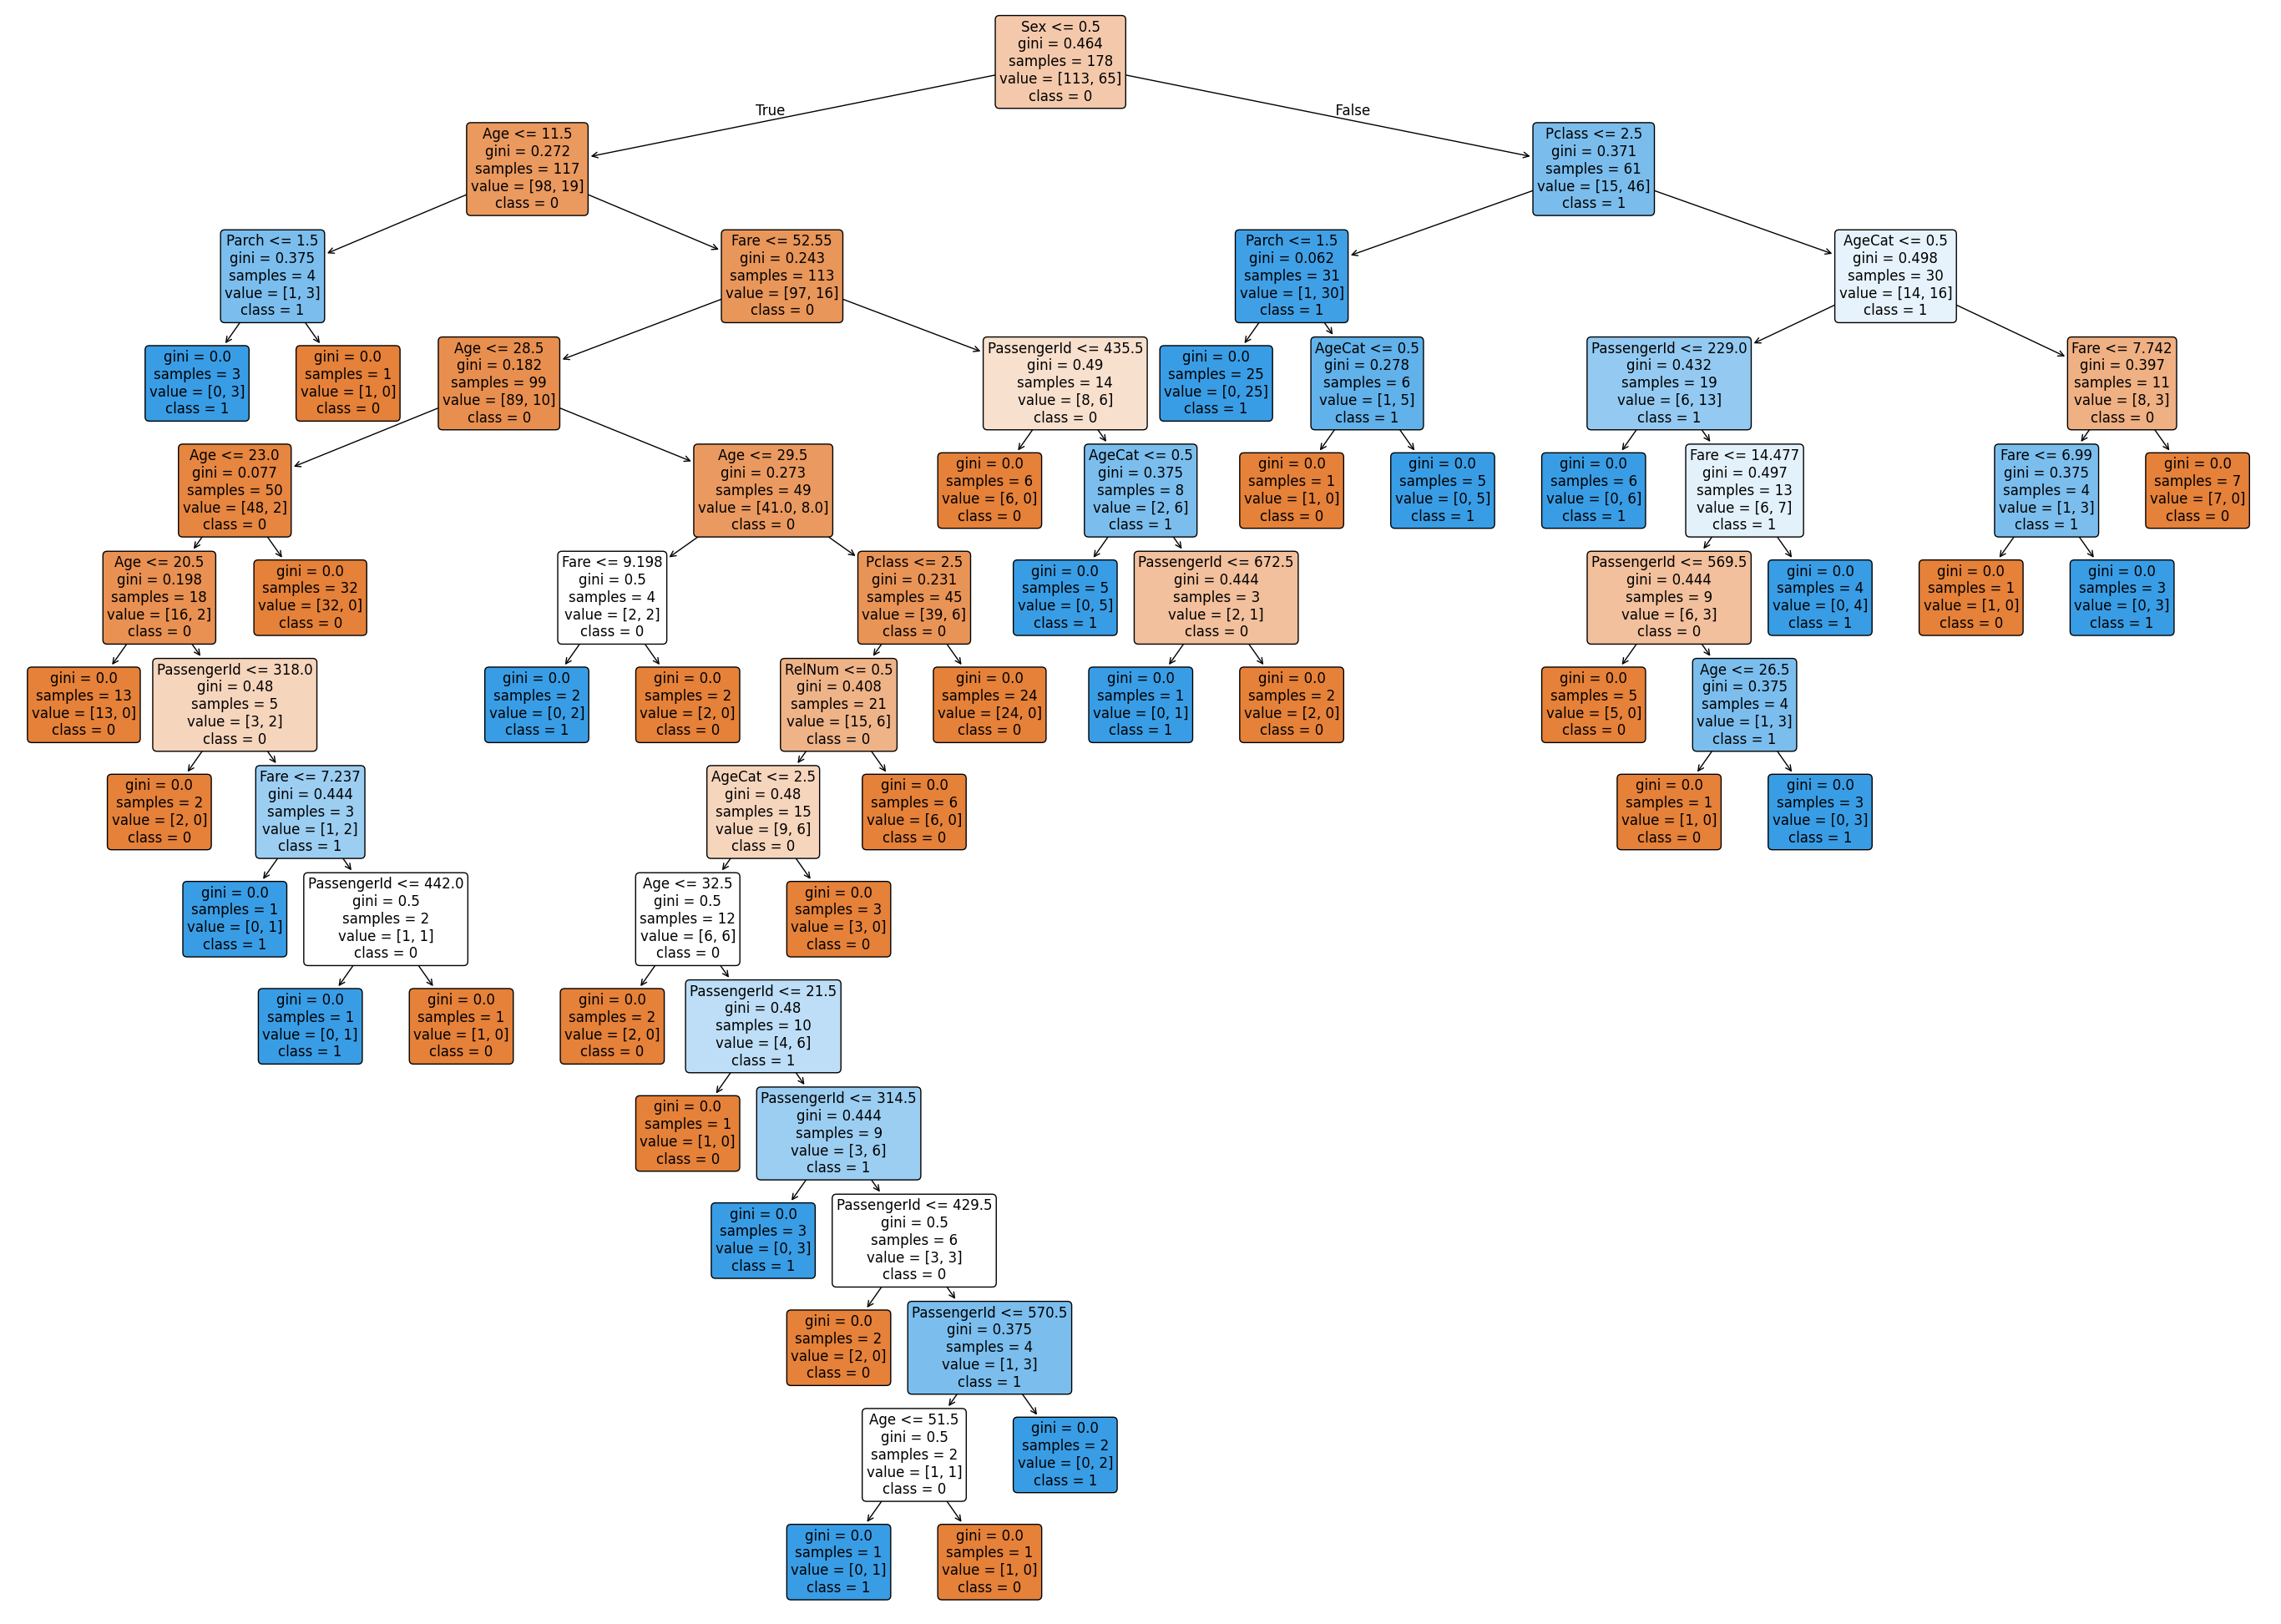

In [20]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

plt.figure(figsize=(35,25))
plot_tree(decision_tree_classifier, feature_names=data_train.columns, class_names=['0','1'], filled=True, rounded=True, fontsize=12)
plt.show()

Dla dalniejszej analizy wybrałam takie 2 hyperparametry: max_depth i min_samples_split

In [21]:
def hyperparameter_tuning(hyperparam, func):
  scores = []
  for i in range(2, 12):
    dfc = DecisionTreeClassifier(**{hyperparam: i}, random_state=42)
    dfc.fit(data_train, target_train)
    dfc_prediction = dfc.predict(data_test)
    scores.append(func(target_test, dfc_prediction))
  return scores

In [22]:
def visualization(scores, interval, hyperparam, name):
  plt.figure(figsize=(10,6))
  plt.plot(interval, scores, marker='o')
  plt.xlabel(hyperparam)
  plt.ylabel(name)
  plt.title(f'{name} vs {hyperparam}')
  plt.grid(True)
  plt.show()


* Max_depth: ogranicza maksymalną głębokość drzewa

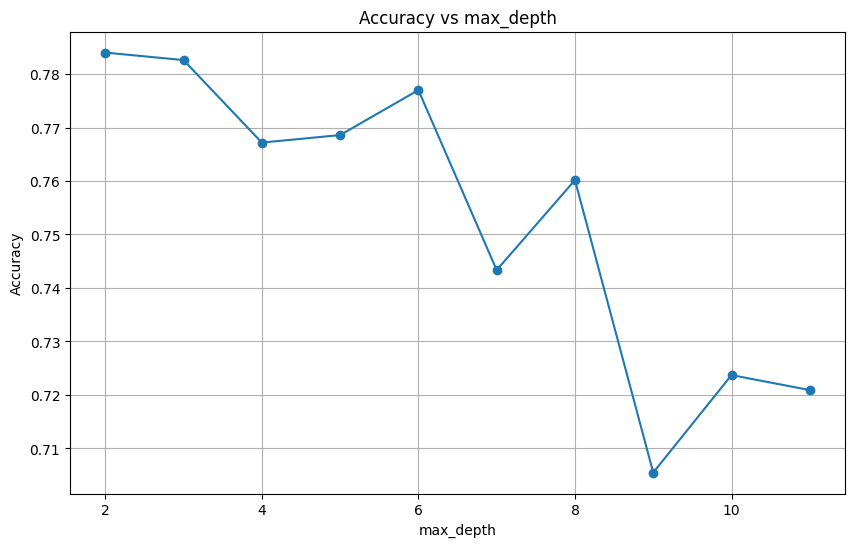

In [23]:
visualization(hyperparameter_tuning('max_depth', accuracy_score), range(2, 12), 'max_depth', 'Accuracy')

Z wykresu widać, że accuracy znacznie maleje wraz ze wzrostem głębokości drzewa zaczynając od 7, co może świadczyć o przeuczeniu modelu

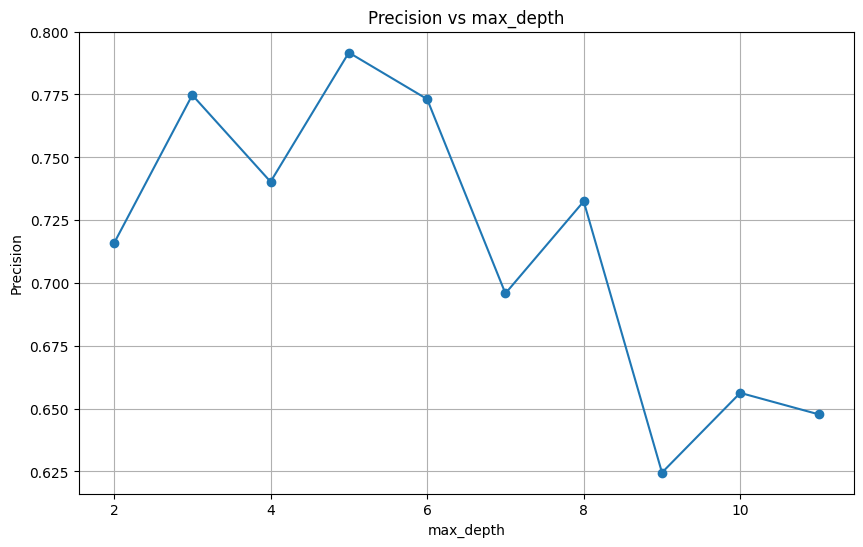

In [24]:
visualization(hyperparameter_tuning('max_depth', precision_score), range(2, 12), 'max_depth', 'Precision')

Na początku, zwiększenie głębokości drzewa pozytywnie wpływa na precision. Ale, zaczynając od 7 znacznie obniża tą metrykę

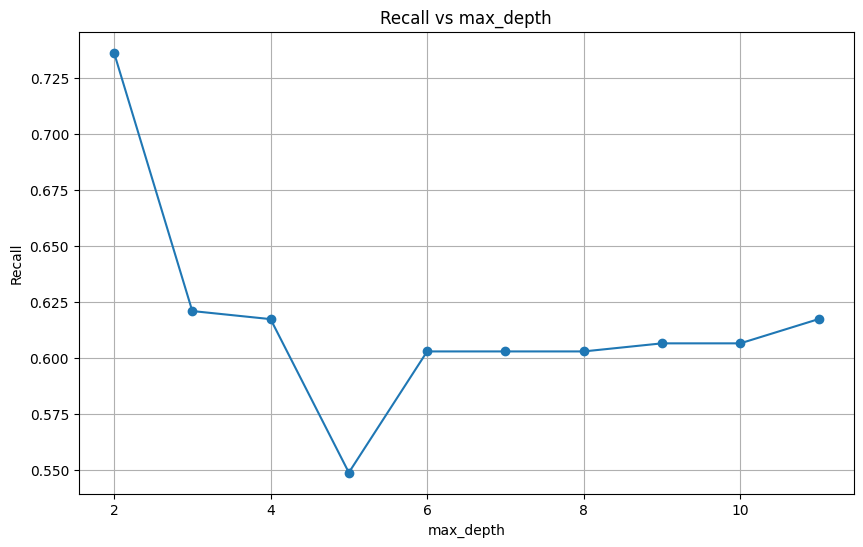

In [25]:
visualization(hyperparameter_tuning('max_depth', recall_score), range(2, 12), 'max_depth', 'Recall')

Głębokość drzewa w średniem nie wpływa na metrykę recall, ba nadal mam mniej więcej ten sam wynik, który otrzymałam przy sprawdzaniu wyników dla DecisionTreeClassifier()

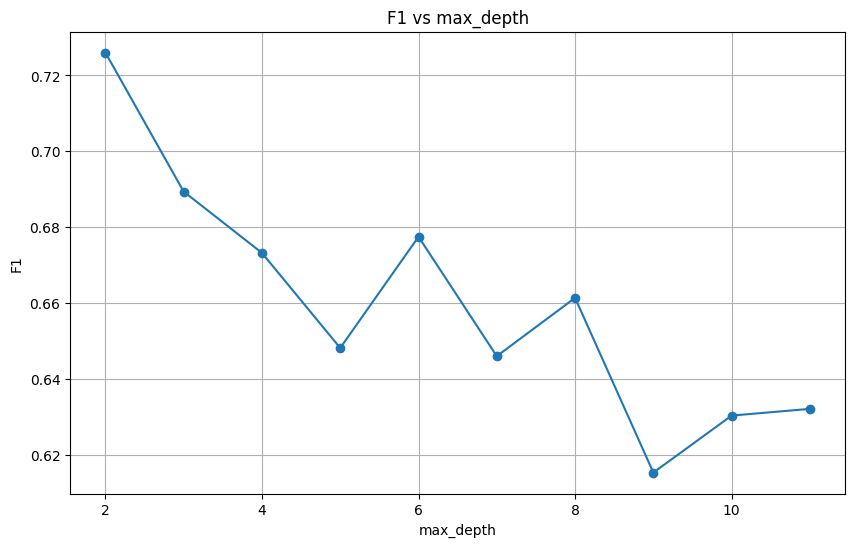

In [26]:
visualization(hyperparameter_tuning('max_depth', f1_score), range(2, 12), 'max_depth', 'F1')

Zwiększenie max_depth negatywnie wpływa na metrykę f1, ale na przedziale od 2 do 8 może być, bo nadal wynik jest większy niż otrzymany bez tej mietryki

Wynik 1: Dodaniu hiperparametru max_depth pozytywnie wpływa na wszystkie metryki, ale gdy jego wartość przekracza 7, wyniki zaczynają spadać, co wskazuje na przeuczenie

* Min_samples_split: ogranicza minimalną liczbę próbek potrzebnych do podziału węzła w drzewie

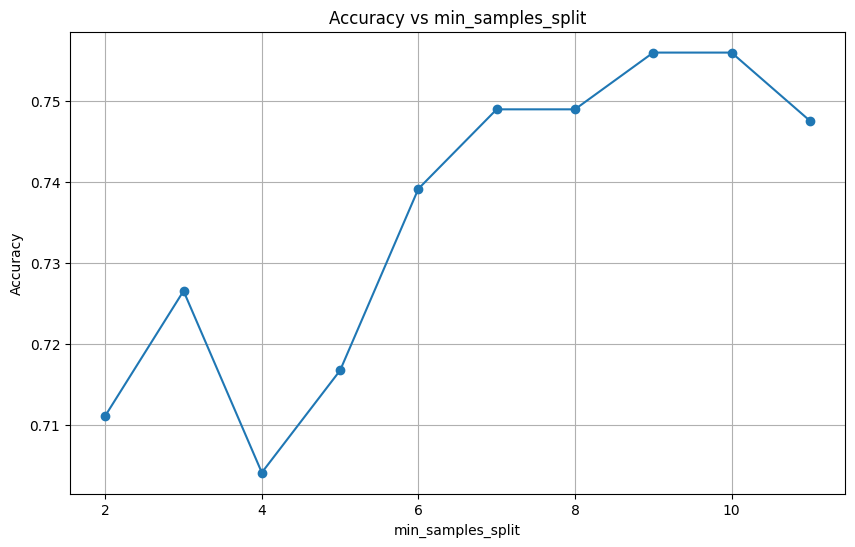

In [27]:
visualization(hyperparameter_tuning('min_samples_split', accuracy_score), range(2, 12), 'min_samples_split', 'Accuracy')

Z wykresu widać, że accuracy rośnie znacząco wraz ze wzrostem wartości parametru min_samples_split na wybranym przedziale, co wskazuje, że większe minimalne liczby próbek wymagane do podziału węzła pomagają drzewu lepiej uogólniać i zmniejszają ryzyko przeuczenia

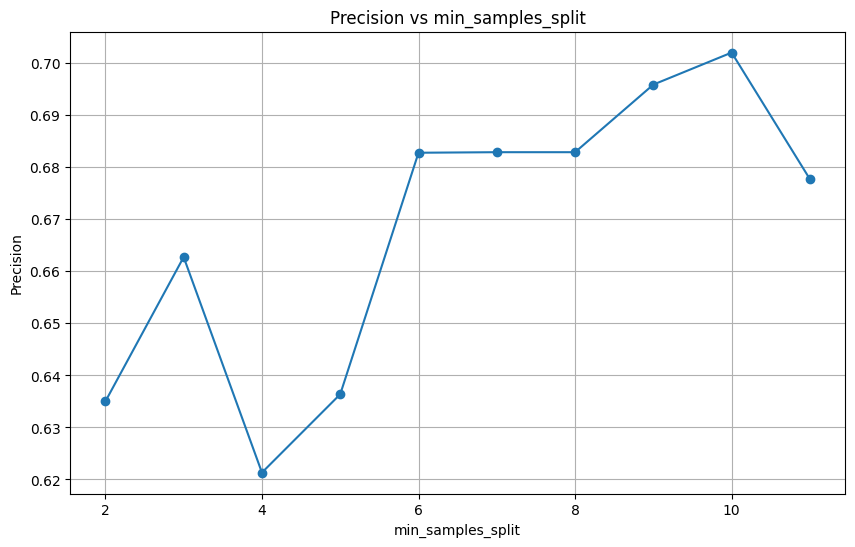

In [28]:
visualization(hyperparameter_tuning('min_samples_split', precision_score), range(2, 12), 'min_samples_split', 'Precision')

Precision znacznie rośnie wraz ze wzrostem wartości hiperparametru min_samples_split. Średnie wartości tej metryki są wyższe niż przy domyślnych ustawieniach, co wskazuje na poprawę trafności prognoz pozytywnych przypadków

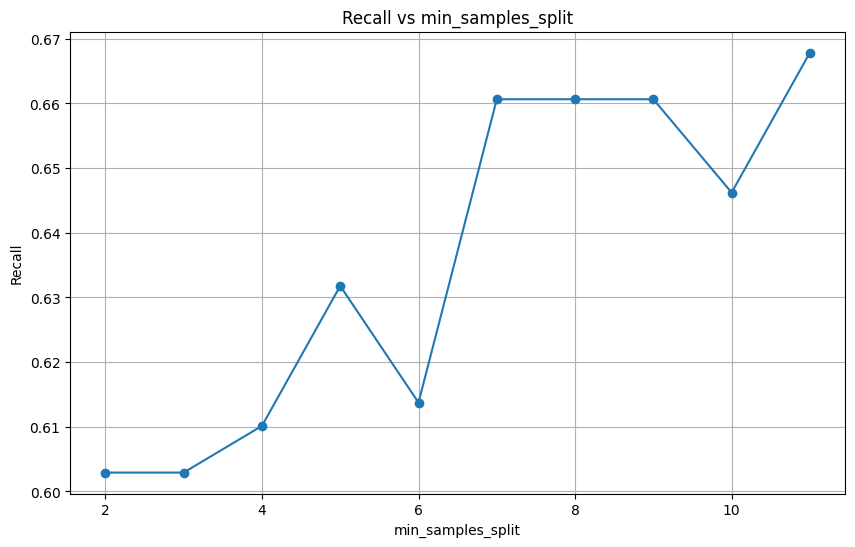

In [29]:
visualization(hyperparameter_tuning('min_samples_split', recall_score), range(2, 12), 'min_samples_split', 'Recall')

Recall rośnie wraz ze wzrostem wartości hiperparametru min_samples_split, co oznacza, że model coraz lepiej wykrywa rzeczywiste przypadki pozytywne

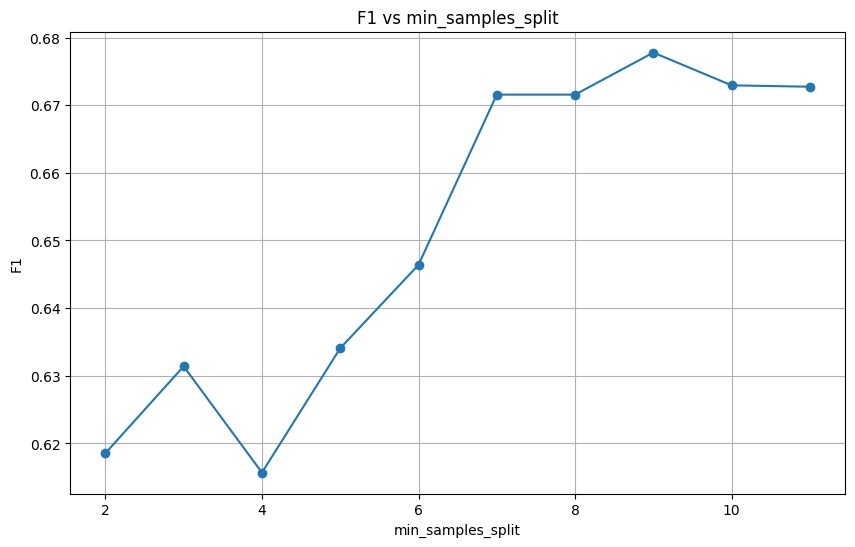

In [ ]:
visualization(hyperparameter_tuning('min_samples_split', f1_score), range(2, 12), 'min_samples_split', 'F1')

F1-score rośnie wraz ze wzrostem wartości hiperparametru min_samples_split, co wskazuje na lepszą równowagę między trafnością a czułością

Wynik 2: zwiększanie wartości hiperparametru min_samples_split poprawia wyniki wszystkich metryk. Na wykresach szczególnie widać wyraźny wzrost, gdy wartość tego parametru przekracza 7

2. KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn_class = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_class.fit(data_train, target_train)

knn_class_prediction = knn_class.predict(data_test)

print('Accuracy: ', round(accuracy_score(target_test, knn_class_prediction), 2))
print('Precision: ', round(precision_score(target_test, knn_class_prediction, zero_division=0), 2))
print('Recall: ', round(recall_score(target_test, knn_class_prediction, zero_division=0), 2))
print('F1: ', round(f1_score(target_test, knn_class_prediction, zero_division=0), 2))


Accuracy:  0.66
Precision:  0.57
Recall:  0.47
F1:  0.51


Porównywanie wyników KNeighborsClassifier i wásnego DummyClassifier:

* Accuracy: dla KNeighborsClassifier(0,66) jest wyższa niż dla DummyClassifier(0,53), co oznacza, że KNeighborsClassifier prognozuje lepiej niż mój DummyClassifier. W porównaniu z DecisionTreeClassifier(0,74) KNeighborsClassifier pokazuje mniejszą accuracy.
* Precision: wyższa wartość dla KNeighborsClassifier(0,57) wskazuje na lepszą trafność prognoz pozytywnych w porównaniu z moim DummyClassifier(0,42). Ale tu też wynik jest gorszy niż dla DecisionTreeClassifier(0,7).
* Recall: mniejsza wartość dla KNeighborsClassifier(0,47) pokazuje gorszą zdolność wykrywania istotnych przypadków niż mój DummyClassifier(0,55). DecisionTreeClassifier tu miał wynik 0,6 (też większy).
* F1-score: wyższy F1 dla KNeighborsClassifier(0,51) świadczy o lepszej równowadze między accuracy i recall w porównaniu z moim DummyClassifier(0,48). Ale DecisionTreeClassifier(0,64) pokazał lepszy wynik

Aby zwizualizowaćmodel KNN

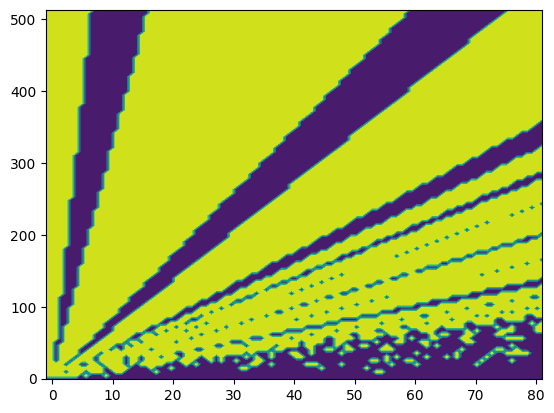

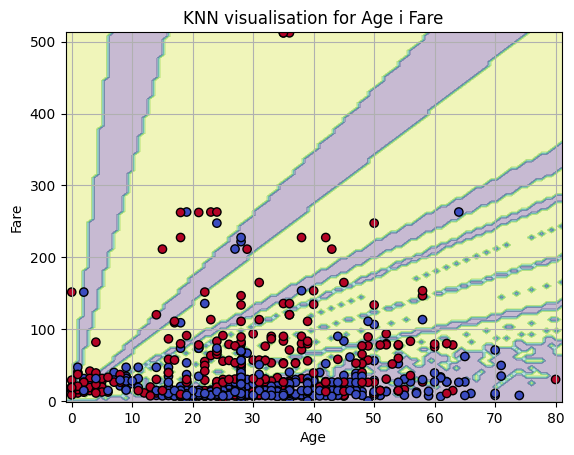

In [31]:
from sklearn.inspection import DecisionBoundaryDisplay
new_data_train = refined_titanic_data_frame[["Age", "Fare"]].values
new_target_train = target_column.values
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')

knn.fit(new_data_train, new_target_train)
dbd = DecisionBoundaryDisplay.from_estimator(knn, new_data_train, response_method="predict")
dbd.plot(alpha=0.3)
plt.scatter(new_data_train[:, 0], new_data_train[:, 1], c=new_target_train, cmap='coolwarm', edgecolor='k')

plt.title("KNN visualisation for Age i Fare")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.grid(True)
plt.show()

Dla dalniejszej analizy wybrałam takie 2 hyperparametry: n_beighbors i weights

In [32]:
def knn_hyperparameters(weightss, n_range, func):
    result = []
    for weight in weightss:
        for n in n_range:
            new_knn = KNeighborsClassifier(n_neighbors=n, weights=weight)
            new_knn.fit(data_train, target_train)
            new_knn_pred = new_knn.predict(data_test)

            score = func(target_test, new_knn_pred)
            result.append({
                "weights": weight,
                "neighbors": n,
                "score": score
            })
    return pd.DataFrame(result)

In [37]:
import seaborn as sns

def knn_visualisation(data_frame, name):
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=data_frame, x="neighbors", y="score", hue="weights", marker="o")
    plt.title(f'{name} vs neighbors and weights')
    plt.xlabel('neighbors')
    plt.ylabel(name)
    plt.grid(True)
    plt.show()

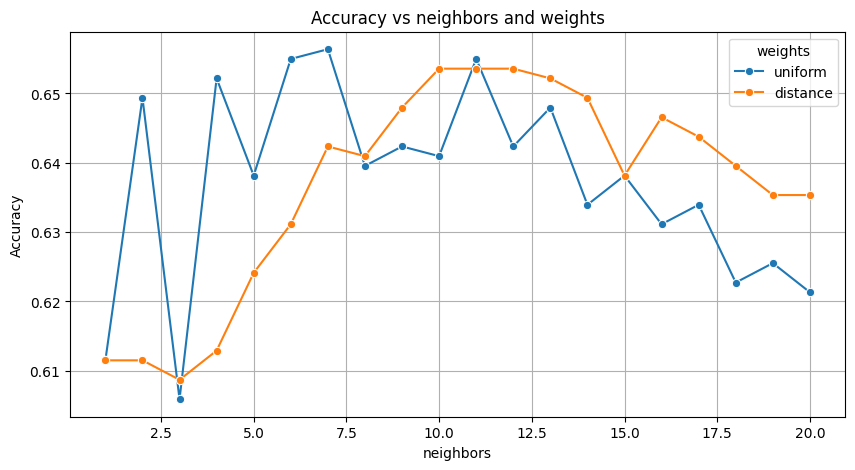

In [38]:
data_frame_accuracy = knn_hyperparameters(['uniform', 'distance'], range(1, 21), accuracy_score)
knn_visualisation(data_frame_accuracy, "Accuracy")

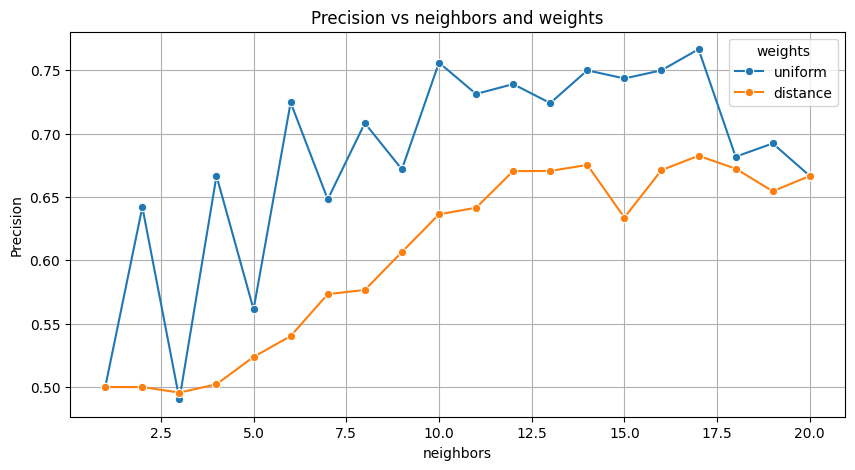

In [39]:
data_frame_precision = knn_hyperparameters(['uniform', 'distance'], range(1, 21), precision_score)
knn_visualisation(data_frame_precision, "Precision")

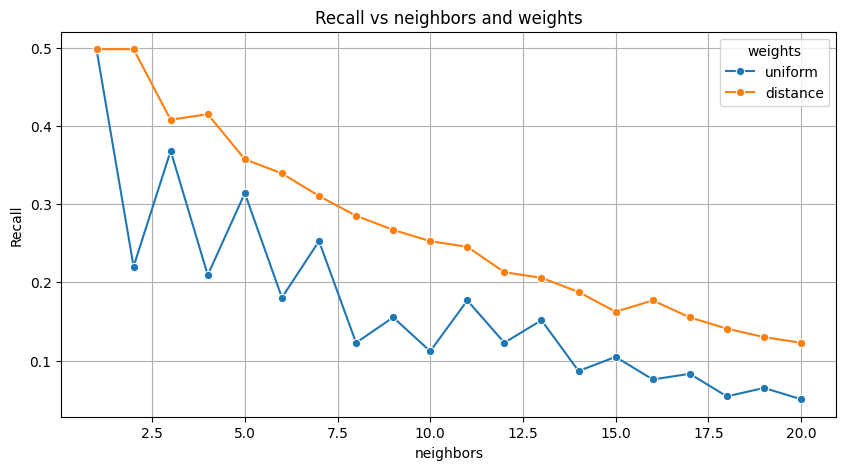

In [40]:
data_frame_recall = knn_hyperparameters(['uniform', 'distance'], range(1, 21), recall_score)
knn_visualisation(data_frame_recall, "Recall")

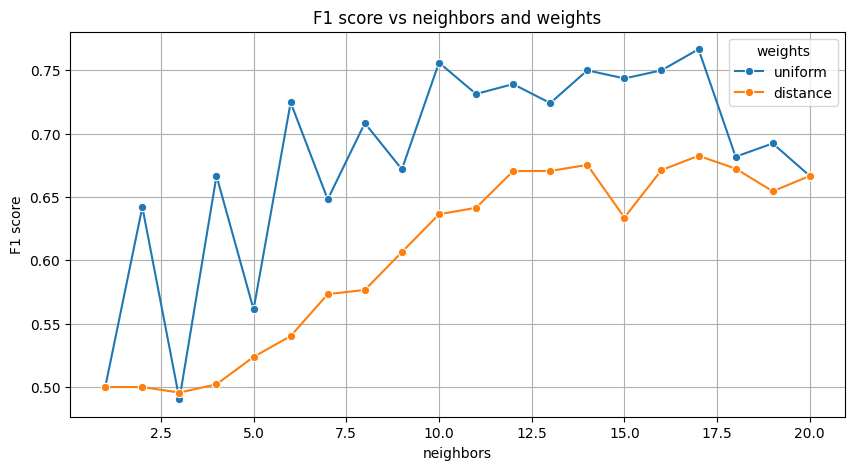

In [41]:
data_frame_f1 = knn_hyperparameters(['uniform', 'distance'], range(1, 21), f1_score)
knn_visualisation(data_frame_precision, "F1 score")

Z wykresów wynika, że wartości F1-score i Precision są lepsze przy ustawieniu parametru weights na uniform, natomiast Recall i Accuracy osiągają wyższe wyniki przy weights = distance.
Zakres liczby sąsiadów n_neighbors od 6 do 17 daje najlepsze rezultaty dla większości metryk.
Wyjątkiem jest Recall, który pozostaje stosunkowo niski niezależnie od ustawienia hiperparametrów

**Ogólny wynik:** analiza wyników pokazuje, że dwie użyte przeze mnie modele DecisionTreeClassifier i KNN osiągają lepsze rezultaty niż Dummy Classifier.
Dobrze dobrane hiperparametry znacząco poprawiają jakość predykcji, jednak modele osiągają optymalne wyniki tylko w odpowiednim zakresie wartości tych hyperparametrów.
Nieprawidłowy dobór parametrów może prowadzić do znacznego spadku skuteczności, szczególnie